First 5 rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0    

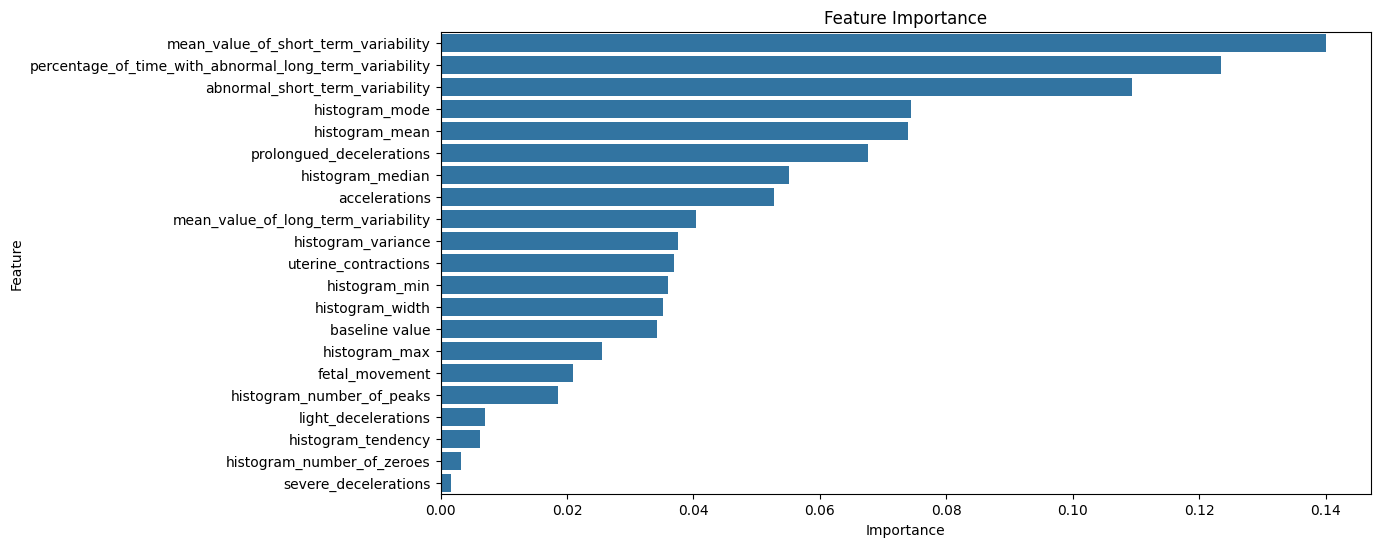


Predicted Fetal Health Class: 3.0
Risk Level: 1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/3rd year/Sem6/ibm z datathon/fetal_health.csv')

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
print(df.head())

# Define ideal thresholds for each feature
ideal_thresholds = {
    'baseline value': 120,
    'accelerations': 10,
    'fetal_movement': 30,
    'uterine_contractions': 5,
    'light_decelerations': 1,
    'severe_decelerations': 0,
    'prolongued_decelerations': 0,
    'abnormal_short_term_variability': 0,
    'mean_value_of_short_term_variability': 6,
    'percentage_of_time_with_abnormal_long_term_variability': 0,
    'mean_value_of_long_term_variability': 8,
    'histogram_width': 20,
    'histogram_min': 0,
    'histogram_max': 100,
    'histogram_number_of_peaks': 2,
    'histogram_number_of_zeroes': 0,
    'histogram_mode': 0,
    'histogram_mean': 5,
    'histogram_median': 5,
    'histogram_variance': 1,
    'histogram_tendency': 1
}

# Function to evaluate risk level based on ideal thresholds
def evaluate_risk(features):
    risk_level = 1  # Default risk level
    for feature, value in features.items():
        if feature in ideal_thresholds:
            if value > ideal_thresholds[feature]:
                risk_level += 1
    return risk_level

# Split the data into features and target
X = df.drop('fetal_health', axis=1)  # Features
y = df['fetal_health']               # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a Pipeline for scaling and modeling with GridSearch
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameters to tune, including regularization
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning with cross-validation to avoid overfitting
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,             # 5-fold cross-validation
    n_jobs=-1,
    scoring='accuracy',
    return_train_score=True  # Return train scores to check for overfitting
)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate using cross-validation on training data to ensure generalization
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean()}")

# Predictions and evaluation on the test set
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(best_model, 'fetal_health_model.pkl')

# Feature Importance Analysis
feature_importances = best_model.named_steps['classifier'].feature_importances_
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.show()

# Function to predict risk level based on input values
def predict_risk(input_features):
    input_df = pd.DataFrame([input_features], columns=X.columns)
    scaled_features = best_model.named_steps['scaler'].transform(input_df)
    predicted_health = best_model.named_steps['classifier'].predict(scaled_features)[0]
    risk = evaluate_risk(dict(zip(X.columns, input_features)))
    return predicted_health, risk

# Example input features for prediction
example_input = [
    120, 10, 30, 5, 1, 0, 0, 0, 6, 0,
    8, 20, 0, 100, 2, 0, 0, 5, 5, 1, 1
]

# Get the prediction
predicted_health, risk_level = predict_risk(example_input)
print("\nPredicted Fetal Health Class:", predicted_health)
print("Risk Level:", risk_level)